# Bike Sharing Demand

#### Data Fields
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals  
  <br><br>
  
#### Evaluation
Submissions are evaluated one the Root Mean Squared Logarithmic Error .

* 자전거 대여량을 예측하는 문제로, 회귀와 관련된 문제

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨진느 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv("C:/Users/yiyeon/TIL/python_study/2. study_Bike-sharing-demand/train.csv", parse_dates=["datetime"])
# datetime 형식으로 불러옴
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("C:/Users/yiyeon/TIL/python_study/2. study_Bike-sharing-demand/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [4]:
# train.columns
# train.dtypes
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
train.temp.describe()   # 통계정보 요약

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [8]:
train.isnull().sum()  # 각 변수별 결측값 확인

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

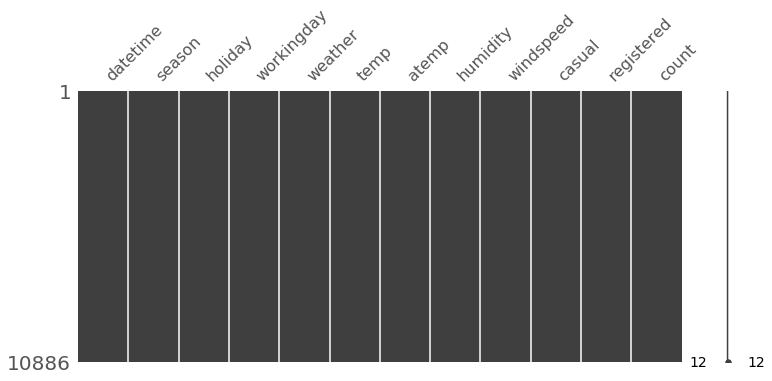

In [10]:
# null 값을 시각화로 확인
import missingno as msno
msno.matrix(train, figsize=(12,5))

## Feature Engineering

In [11]:
# datetime으로 되어있는 데이터를 column으로 세분화시킴 => column이 18개로 늘어남
train['year']=train['datetime'].dt.year
train['month']=train['datetime'].dt.month
train['day']=train['datetime'].dt.day
train['hour']=train['datetime'].dt.hour
train['minute']=train['datetime'].dt.minute
train['second']=train['datetime'].dt.second
train['dayofweek']=train['datetime'].dt.dayofweek

train.shape

(10886, 19)

In [12]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [13]:
test['year']=test['datetime'].dt.year
test['month']=test['datetime'].dt.month
test['day']=test['datetime'].dt.day
test['hour']=test['datetime'].dt.hour
test['minute']=test['datetime'].dt.minute
test['second']=test['datetime'].dt.second
test['dayofweek']=test['datetime'].dt.dayofweek

test.shape

(6493, 16)

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, 'hour')]

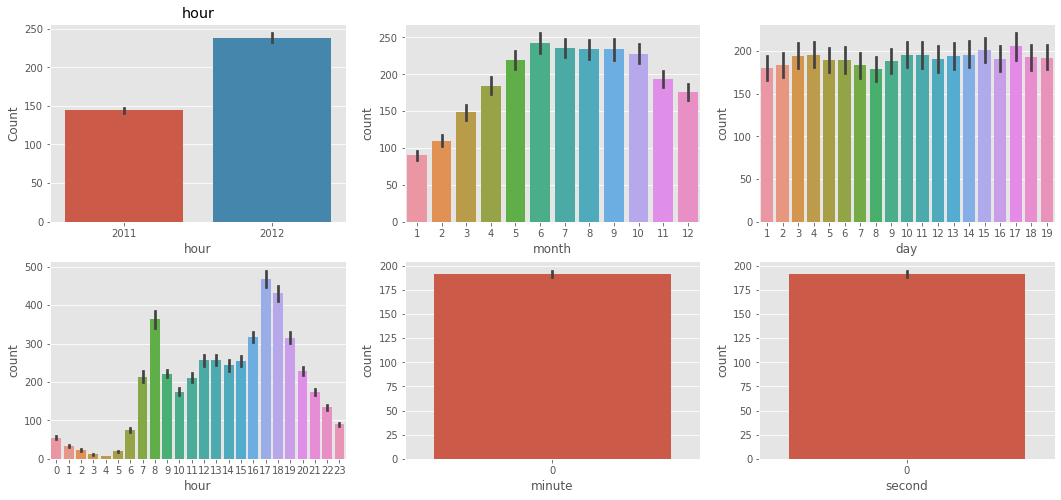

In [14]:
# 시간별 데이터에 따라 대여량이 어떻게 되는지 시각화
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)
sns.barplot(data=train, x='day', y='count', ax=ax3)
sns.barplot(data=train, x='hour', y='count', ax=ax4)
sns.barplot(data=train, x='minute', y='count', ax=ax5)
sns.barplot(data=train, x='second', y='count', ax=ax6)

ax1.set(ylabel='Count', title='year')
ax1.set(xlabel='month', title='month')
ax1.set(xlabel='day', title='day')
ax1.set(xlabel='hour', title='hour')
# 일별대여량은 참고만하되 사용할 수 없음(train data는 19일까지 test data는 20일부터 있음)

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'rental_workingday')]

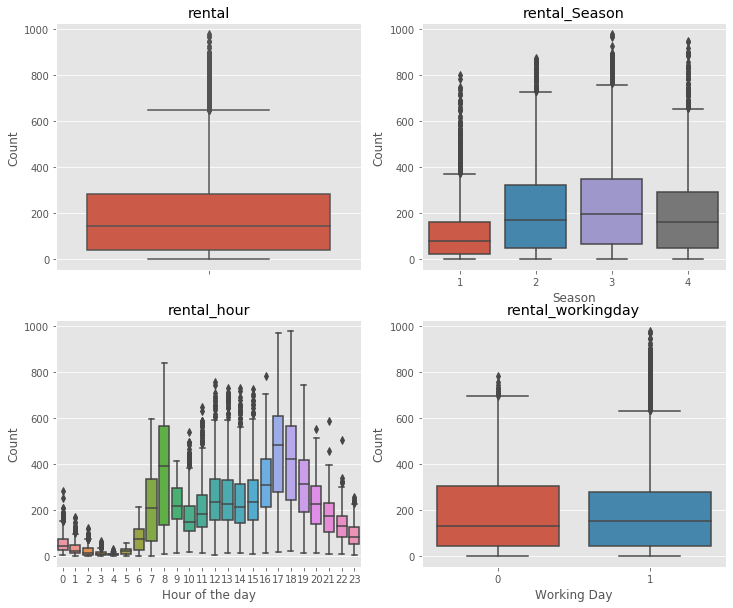

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12,10)
sns.boxplot(data=train, y='count', orient='v', ax=axes[0][0])
sns.boxplot(data=train, y='count', x='season', orient='v', ax=axes[0][1])
sns.boxplot(data=train, y='count', x='hour', orient='v', ax=axes[1][0])
sns.boxplot(data=train, y='count', x='workingday', orient='v', ax=axes[1][1])

axes[0][0].set(ylabel='Count', title="rental")
axes[0][1].set(xlabel='Season', ylabel=
               'Count', title="rental_Season")
axes[1][0].set(xlabel='Hour of the day', ylabel=
               'Count',  title="rental_hour")
axes[1][1].set(xlabel='Working Day', ylabel=
               'Count',  title="rental_workingday")


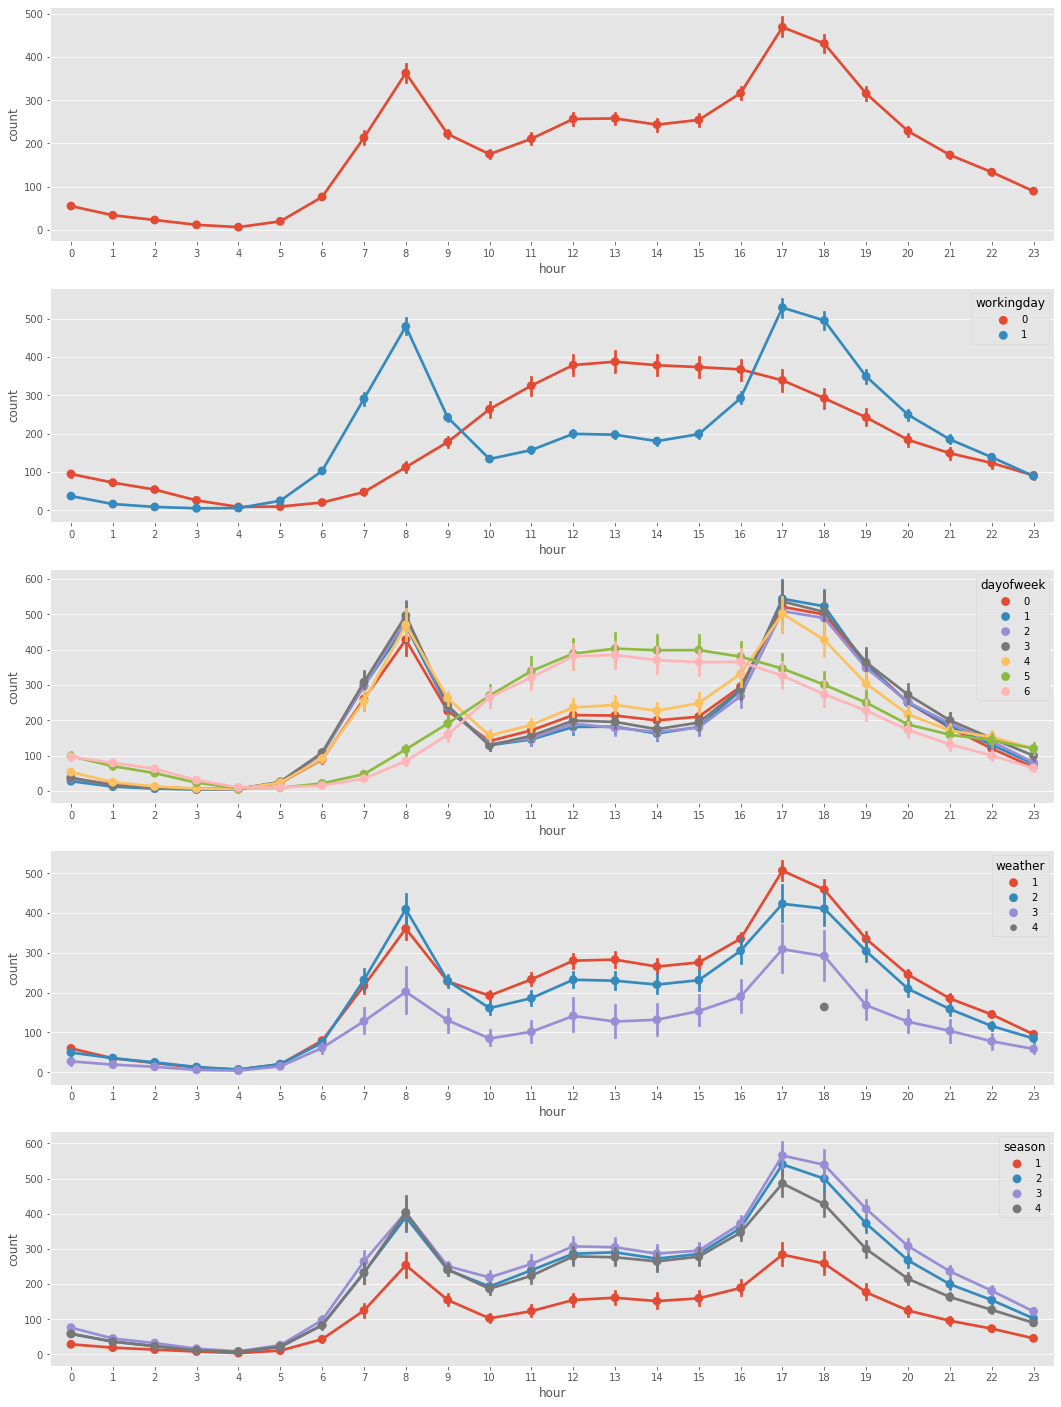

In [16]:
fig, (ax1,ax2,ax3,ax4,ax5)=plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x='hour', y='count', ax=ax1)
sns.pointplot(data=train, x='hour', y='count', hue='workingday', ax=ax2)
sns.pointplot(data=train, x='hour', y='count', hue='dayofweek', ax=ax3)
sns.pointplot(data=train, x='hour', y='count', hue='weather', ax=ax4)
sns.pointplot(data=train, x='hour', y='count', hue='season', ax=ax5)

In [17]:
# 각 변수별 상관관계 파악
corrMatt = train[['temp', 'atemp','casual','registered','humidity','windspeed','count']]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


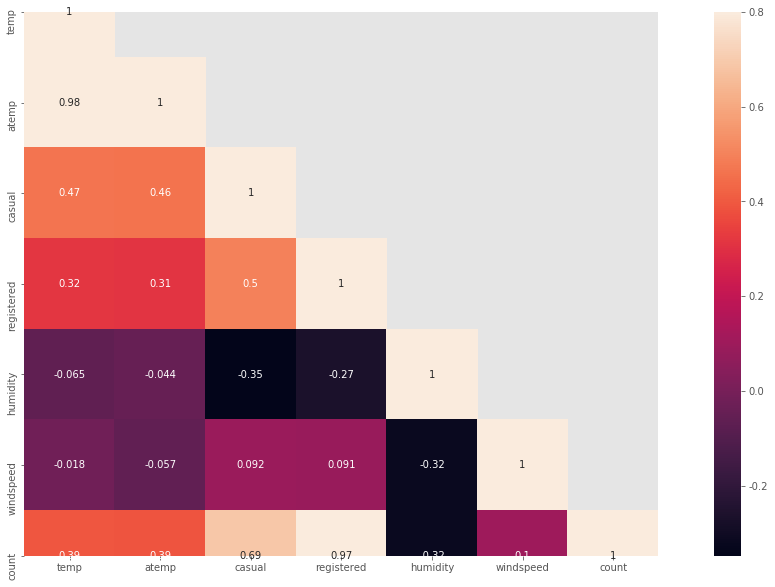

In [18]:
# heatmap
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

- 온도, 습도, 풍속은 거의 상관관계가 없다
- 대여량과 가장 연관이 높은 것은 registered로 등록된 대여자가 많지만, test 데이터에는 이 값이 없다
- atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다. => 상관관계가 너무 높기때문에 거의 동일한 data로 보여짐

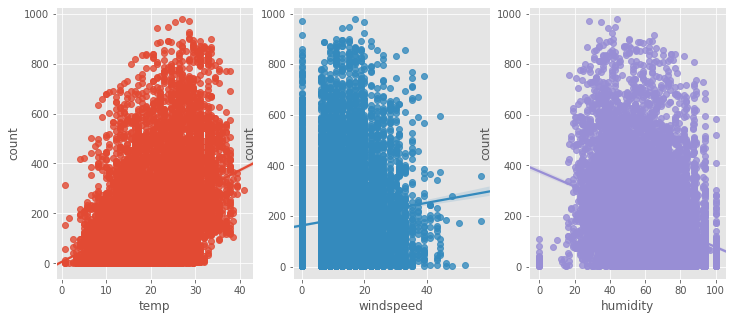

In [19]:
# 온도, 습도, 풍속으로 산점도를 그림
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x='temp',y='count', data=train, ax=ax1)
sns.regplot(x='windspeed',y='count', data=train, ax=ax2)
sns.regplot(x='humidity',y='count', data=train, ax=ax3)

- 풍속의 경우 0에 숫자가 몰려 있는 것으로 보임. 아마 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측함

In [20]:
# 연-월을 붙여서 확인
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concatenate_year_month)

print(train.shape)
train[['datetime', 'year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


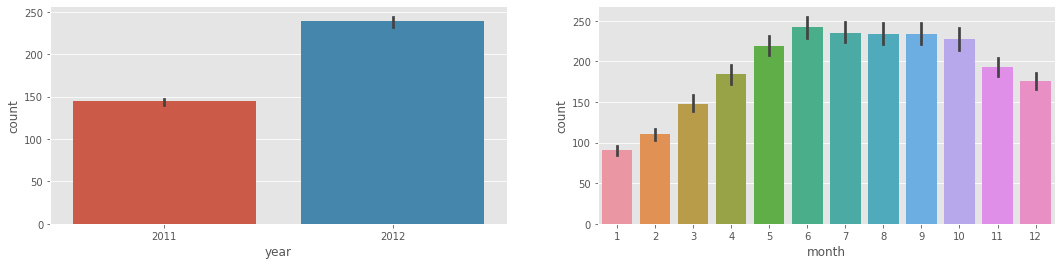

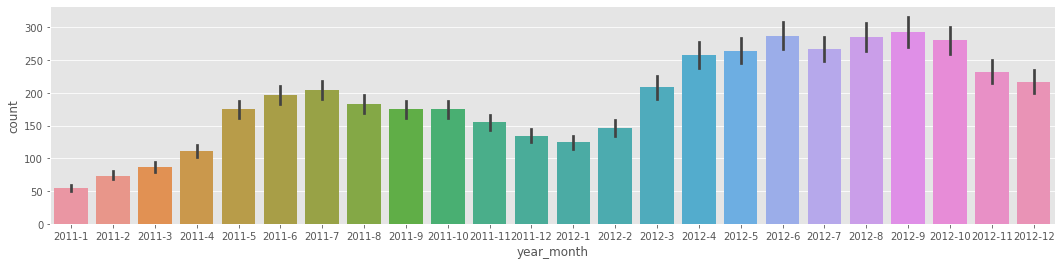

In [21]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year', y='count', ax=ax1)
sns.barplot(data=train, x='month', y='count', ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year_month', y='count', ax=ax3)


- 2011년보다 2012년의 대여량이 더 많다.
- 겨울보다는 여름에 대여량이 많다
- 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세이다.

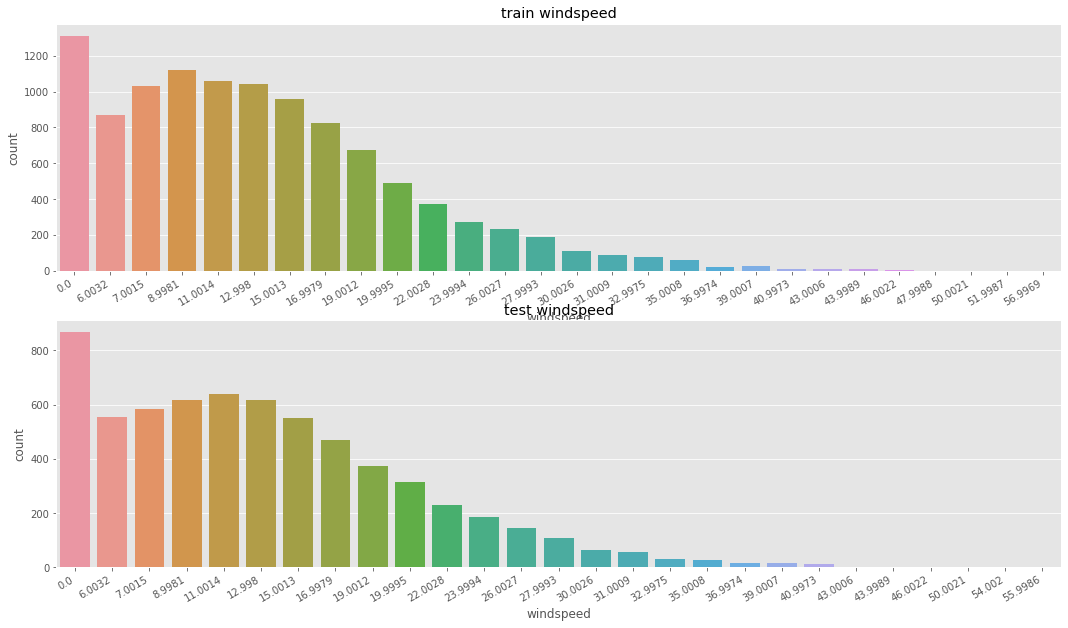

In [22]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [23]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [24]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

C:\Users\yiyeon\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\yiyeon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\yiyeon\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


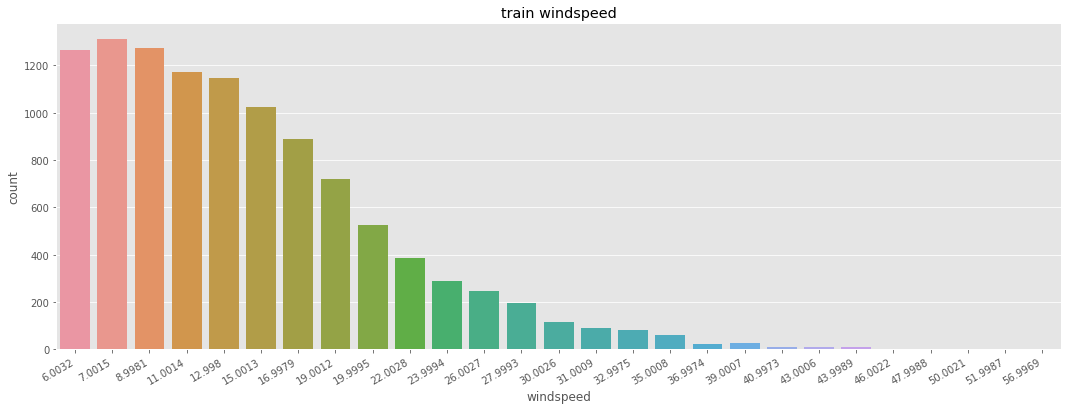

In [25]:
# 0값을 조정한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

In [26]:
# trainWithoutOutliers (outliers data 제거)
# 대여량이 0에 몰려있는 경우, 한쪽에 치우쳐진 경우 제거
trainWithoutOutliers = train[np.abs(train['count']-train['count'].mean()) <= (3*train['count'].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

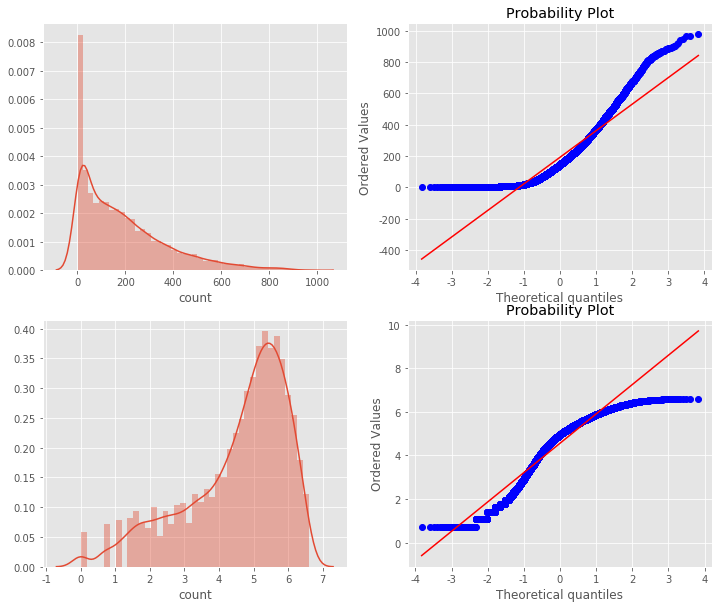

In [27]:
# count값의 데이터 분포도를 파악
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.

## Feature Selection

* 신호와 소음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [41]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",         "dayofweek","month","year","hour"]

In [42]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed", "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [43]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [44]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [45]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## Score

In [46]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

## 데이터 분석

### 1. 선형회귀 모델

In [47]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9798701813976344


### 2. 릿지 Regularization Model -Ridge

- 회귀를 위한 선형모델  
- 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)  
- Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미  
- max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [49]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9798701793927495


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019350,0.008310,0.009972,0.001994,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.995605,-0.899086,-1.052809,-0.960073,-1.037271,-0.988970,0.055435,1
1,0.013563,0.004350,0.007290,0.002950,0.10,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.995607,-0.899085,-1.052811,-0.960071,-1.037272,-0.988970,0.055436,2
2,0.011371,0.002791,0.005688,0.002751,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.995627,-0.899080,-1.052824,-0.960043,-1.037279,-0.988971,0.055446,3
3,0.016355,0.003918,0.008681,0.003367,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.995649,-0.899073,-1.052838,-0.960012,-1.037287,-0.988972,0.055456,4
4,0.011674,0.002313,0.007385,0.003126,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.995671,-0.899067,-1.052853,-0.959981,-1.037295,-0.988974,0.055467,5


In [50]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.988970
1,0.10,0.988970
2,1.00,0.988971
3,2.00,0.988972
4,3.00,0.988974


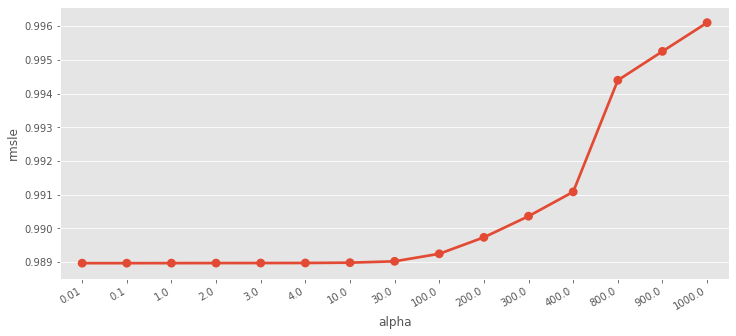

In [51]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### 3. 라쏘 Regularization Model - Lasso
- 선형회귀의 Regularization(규제)를 적용하는 대안
- 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
- 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
- alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
- 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025 max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [53]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.0033333333333333335, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9798830628143598


,alpha,rmsle
0,10.000000,1.389636
1,1.000000,1.060860
2,0.500000,1.050022
3,0.333333,1.048503
4,0.250000,1.048312


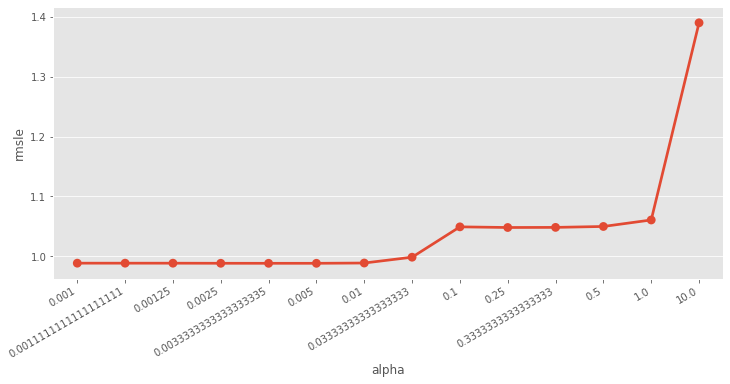

In [54]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### 앙상블모델 - 랜덤포레스트(Ensemble Models - Random Forest)

In [55]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10563825721116558


### 앙상블모델 - 그라디언트 부스트
Ensemble Model - Gradient Boost
- 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
- 회귀와 분류에 모두 사용할 수 있음
- 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
- 무작위성이 없고 강력한 사전 가지치기가 사용 됨
1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
- learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
- n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
- max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.20370107464329062


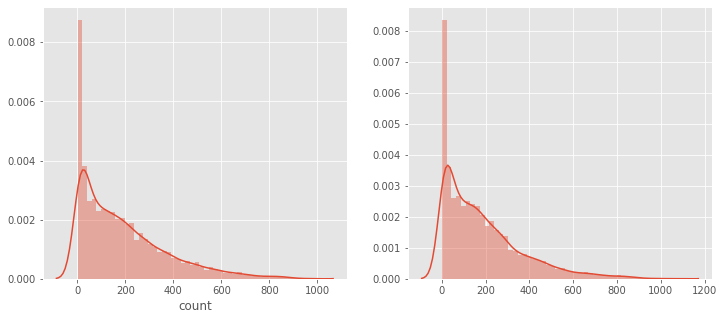

In [57]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)